In [1]:
from time import time
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from time import time
from bin_model import MyModel
from helpers import printm
from PCA import CustomPCA
import cv2 as cv
import numpy as np
import pandas as pd
from helpers import printm


In [2]:
def get_text(original, img, cnt_all, start, line, size):
  #Find the closeset contour to the start point
  prime_cnt = sorted(cnt_all, key=lambda cnt: abs(cv.pointPolygonTest(cnt,start,True)))[0]

  take_x = lambda dot: dot[0][0]
  take_y = lambda dot: dot[0][1]

  #Find coordinate of squre
  y_0 = min(prime_cnt, key=take_y)[0][1] + line
  x_0 = min(prime_cnt, key=take_x)[0][0] + line
  y_1 = max(prime_cnt, key=take_y)[0][1] - line
  x_1 = max(prime_cnt, key=take_x)[0][0] - line

  center_y = y_0 + (y_1 - y_0)//2
  center_x = x_0 + (x_1 - x_0)//2

  resize = lambda image: cv.resize(image, (size, size), interpolation = cv.INTER_CUBIC)
  return map(resize, [original[y_0: center_y, x_0: center_x],
                      original[y_0: center_y, center_x: x_1],
                      original[center_y: y_1, x_0: center_x],
                      original[center_y: y_1, center_x: x_1]])

In [3]:
def standartize(dataset):
  output_dataset = []
  for img in dataset:
    new_img = []
    for row in img:
      for pixel in row:
        value = int(abs(255-((0.3 * pixel[0]) + (0.59 * pixel[1]) + (0.11 * pixel[2]))))
        new_img.append(value if value > 70 else 0)
    output_dataset.append(new_img)
  return output_dataset

In [4]:
def convert_to_standart(path):
    image = cv.imread(path)
    #cv2_imshow(image)

    #Left upper angle
    START_1 = (0, 0)

    #Right upper angle
    START_2 = (len(image[0]), 0)

    #Line width
    LINE = 14

    #Size of digit
    SIZE = 28

    #Process image
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    blur = cv.GaussianBlur(gray, (5,5), 0)
    thresh = cv.adaptiveThreshold(blur, 255, 1, 1, 11, 2)

    #Get contours of image
    contours, _ = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    #Get rid of dots and other lines that defenetly can not have area
    #and be squres that we are searching for
    contours = list(filter(lambda cnt: cv.contourArea(cnt) > 1000, contours))
        
    full = list(get_text(image, thresh, contours, START_1, LINE, SIZE)) + list(get_text(image, thresh, contours, START_2, LINE, SIZE))
    return np.array(standartize(full))

In [5]:
def forest_bench(train: dict, predict: list):
    clf = RandomForestClassifier()
    clf.fit(train['data'], train['label'])
    return clf.predict(predict)

In [6]:
handwritten = pd.read_csv("data/bin.csv")
handwritten_data, handwritten_labels = handwritten.drop(["label"], axis=1).values, handwritten["label"]

In [7]:
rocketbook = { 
    'data':  handwritten_data,
    'label': handwritten_labels
}

In [8]:
processed = convert_to_standart("data/photos/0.jpg")

In [9]:
forest_bench(rocketbook, processed)

array([1, 0, 0, 0, 1, 1, 0, 0])

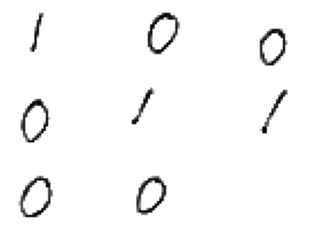

In [10]:
printm(processed)